#### Matrix factorization via NN, contrasting MAE with surpriselib's baseline algos SVD, SVD++

In [120]:
import os
import numpy as np
import pandas as pd


data_path = os.path.expanduser('C:\\Users\\might\\Desktop\\jupyter notebooks\\u.data')

* #### original df containing all 100k data points

In [137]:
df = pd.read_csv(data_path, sep='\t', header=None)
df[2]= df[2].apply(lambda x: int(x>3))#since in df, no. vals holding 1 ratings:6110, 2 ratings:11370, 3 ratings:27145, 4 ratings:34174, 5 ratings: 21201 
df.head(5)#Therefore all ratings(55375) of 4,5 squished to 1 & all ratings(44625) of 1,2,3 are squished to 0

,0,1,2,3
0,196,242,0,881250949
1,186,302,0,891717742
2,22,377,0,878887116
3,244,51,0,880606923
4,166,346,0,886397596


In [5]:
shuffled_df = df.loc[np.random.randint(0, 100000, size=df.shape[0])]

#sm_train_df = shuffled_df[:80000]#small dataframe, trimming data points to random 2000 datapoints
#test_df= shuffled_df[-20000:]

#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)
print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


* #### Training & testing results with SVD from surpriselib
    * Using same dataframes for all three
    * n_factors= 100, epochs= 40

In [6]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

from surprise.model_selection import train_test_split

rdr = Reader(rating_scale=(0,1))
#train_data = Dataset.load_from_df(sm_train_df[[0,1,2]], reader= rdr)
data = Dataset.load_from_df(shuffled_df[[0,1,2]], reader= rdr)

#trainset = train_data.build_full_trainset()#contains 80k data points

trainset, testset = train_test_split(data, test_size=0.2)
#both trainset & testset have their ratings value swapped from 1 in place of 0; and 2 in place of 1

#test_data= Dataset.load_from_df(test_df[[0,1,2]], reader= rdr)
#testset = test_data.build_full_trainset().build_testset()#testset for surprise.SVD

In [55]:
from surprise import accuracy
import time

t1= time.time()

algo_svd = SVD(n_factors=100, n_epochs=40)

algo_svd.fit(trainset)

print('training time:', time.time()-t1)

training time: 7.292524099349976


In [56]:
pred = algo_svd.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse: {}, mae: {}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3725
MAE:  0.3045

Test results on 80k training data & 20k test data -- rmse: 0.3725005375154264, mae: 0.3045276583389787


* #### Creating confusion matrix

In [239]:
pred_arr= pd.DataFrame(pred)
pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))
pred_arr.head(7)

,uid,iid,r_ui,est,details
0,409,854,1.0,1.0,{'was_impossible': False}
1,456,608,1.0,0.0,{'was_impossible': False}
2,474,294,0.0,1.0,{'was_impossible': False}
3,276,82,1.0,1.0,{'was_impossible': False}
4,91,1050,0.0,1.0,{'was_impossible': False}
5,178,317,1.0,1.0,{'was_impossible': False}
6,851,1009,0.0,1.0,{'was_impossible': False}


In [264]:
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]

9526

In [272]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]

6822

In [271]:
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]

1470

In [280]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]

2182

In [286]:
def confusion_matrix(pred):
    pred_arr= pd.DataFrame(pred)
    pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))#changing prediction values to just 0s & 1s
    pred_arr= np.asarray(pred_arr)[:,:4]#contains first 4 cols of pred array, removing timestamp
    
    conf_df = pd.DataFrame(index=['True rating 1', 'True rating 0'], columns=['Estimated rating 1', 'Estimated rating 0'])
    
    conf_df['Estimated rating 1']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]#True Positives, 9526
    conf_df['Estimated rating 0']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]#True Negatives, 6822
    conf_df['Estimated rating 0']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]#False Negatives, 1470
    conf_df['Estimated rating 1']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]#False Positives, 2182
    
    return np.asarray(conf_df), conf_df

In [287]:
confusion_mat, confusion_df = conf_mat(pred)
confusion_df

,Estimated rating 1,Estimated rating 0
True rating 1,9526,1470
True rating 0,2182,6822


In [288]:
print(confusion_mat)

[[9526 1470]
 [2182 6822]]


* ### Testing with individual cases

In [48]:
testcase = testset[np.random.randint(len(testset))]
print(testcase)

(716, 480, 2.0)


In [166]:
# int(testcase[2]>1) ;  because testset contains labels 0 in original df as 1 & 1 as 2
print('\nPredictions with SVD :\n', algo_svd.predict(testcase[0], testcase[1], int(testcase[2]>1), verbose=True))

user: 716        item: 480        r_ui = 1.00   est = 0.98   {'was_impossible': False}

Predictions with SVD :
 user: 716        item: 480        r_ui = 1.00   est = 0.98   {'was_impossible': False}


* #### Training & testing results with SVD++ from surpirselib
    * Using same dataframes for both
    * n_factors= 100, epochs= 40

In [46]:
from surprise import SVDpp

t1= time.time()

algo_svdpp = SVDpp(n_factors=100, n_epochs=40)

algo_svdpp.fit(trainset)

print('training time:', time.time()-t1)


training time: 775.9093706607819


In [47]:
pred = algo_svdpp.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse:{}, mae:{}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3543
MAE:  0.2791

Test results on 80k training data & 20k test data -- rmse:0.35433296400534825, mae:0.2791093764734291


In [54]:
print('\nPredictions with SVD++:\n', algo_svdpp.predict(testcase[0], testcase[1], testcase[2], verbose=True))

user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}

Predictions with SVD++:
 user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}


* #### Training & testing results with matrix factorization implemented with NN
    * Using same dataframes as above
    * Latent vector (k) size : 100, epochs =40

In [99]:
#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)

print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


In [100]:
shuffled_df.head(5)

,0,1,2,3
94422,378,38,0,880333383
89311,894,313,1,883518874
32277,498,1007,0,881954219
70178,10,617,1,877892160
30079,57,126,0,883697293


In [58]:
print('max value of user id:', max(shuffled_df[0]),'\nmax value of movie id:', max(shuffled_df[1]),'\nTherefore concatenated shape of input layer:',(max(shuffled_df[0])+max(shuffled_df[1]),))

max value of user id: 943 
max value of movie id: 1682 
Therefore concatenated shape of input layer: (2625,)


In [60]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.


In [61]:
x_train_user_in = to_categorical(shuffled_df[0])#contains the one-hot encoded user_id data, shaped (batch_size, max(sm_df[0]))
x_train_movie_in = to_categorical(shuffled_df[1])#contains the one-hot encoded movie_id data, shaped (batch_size, max(sm_df[1]))

y_ratings= shuffled_df[2]
print('shape of x_train_user_in:', x_train_user_in.shape,'\nshape of x_train_movie_in:', x_train_movie_in.shape,
      '\nshape of x_train_user_in:',y_ratings.shape)

shape of x_train_user_in: (100000, 944) 
shape of x_train_movie_in: (100000, 1683) 
shape of x_train_user_in: (100000,)


In [62]:
user_in_layer = Input(shape=(max(shuffled_df[0])+1,))#top half of input layer,+1 to accomodate on-hot encoded vectors
movie_in_layer = Input(shape=(max(shuffled_df[1])+1,))#bottom half of input layer

#total input moves as concatenated user_id & movie_id one-hot encoded forms

hid_layer_u = Dense(100)(user_in_layer)#latent dimension k=100 for user_id #_Embedding(100, )
hid_layer_m= Dense(100)(movie_in_layer)#latent dimension k=100 for movie_id

merge_layer = keras.layers.dot([hid_layer_u, hid_layer_m], axes=1)



predictions = Dense(1, activation='sigmoid')(merge_layer)

model = Model(inputs=[user_in_layer, movie_in_layer], outputs= predictions)

model.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [109]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 944)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1683)         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          94500       input_7[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 100)          168400      input_8[0][0]                    
__________________________________________________________________________________________________
dot_3 (Dot

In [98]:
from keras.callbacks import ModelCheckpoint

checkpoints = ModelCheckpoint('./NN_m_factorization_weights.{epoch:02}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', period=2)

In [71]:
??keras.callbacks.ModelCheckpoint

In [99]:
history = model.fit([x_train_user_in, x_train_movie_in], y_ratings, verbose=1, epochs=40, batch_size=32, validation_split=0.2, callbacks=[checkpoints])

Train on 80000 samples, validate on 20000 samples
Epoch 1/40
80000/80000 [==============================] - 5s 65us/step - loss: 0.6864 - mean_absolute_error: 0.4934 - acc: 0.5561 - val_loss: 0.6872 - val_mean_absolute_error: 0.4941 - val_acc: 0.5524
Epoch 2/40
80000/80000 [==============================] - 5s 65us/step - loss: 0.6863 - mean_absolute_error: 0.4935 - acc: 0.5561 - val_loss: 0.6870 - val_mean_absolute_error: 0.4938 - val_acc: 0.5524

Epoch 00002: val_loss improved from inf to 0.68703, saving model to ./NN_m_factorization_weights.02-0.69.hdf5
Epoch 3/40
80000/80000 [==============================] - 5s 66us/step - loss: 0.6861 - mean_absolute_error: 0.4933 - acc: 0.5561 - val_loss: 0.6868 - val_mean_absolute_error: 0.4935 - val_acc: 0.5524
Epoch 4/40
80000/80000 [==============================] - 5s 65us/step - loss: 0.6858 - mean_absolute_error: 0.4931 - acc: 0.5561 - val_loss: 0.6865 - val_mean_absolute_error: 0.4935 - val_acc: 0.5524

Epoch 00004: val_loss improved fro

80000/80000 [==============================] - 5s 63us/step - loss: 0.5243 - mean_absolute_error: 0.3532 - acc: 0.7387 - val_loss: 0.5489 - val_mean_absolute_error: 0.3655 - val_acc: 0.7208
Epoch 34/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5236 - mean_absolute_error: 0.3523 - acc: 0.7407 - val_loss: 0.5509 - val_mean_absolute_error: 0.3683 - val_acc: 0.7181

Epoch 00034: val_loss did not improve from 0.54926
Epoch 35/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5229 - mean_absolute_error: 0.3520 - acc: 0.7398 - val_loss: 0.5536 - val_mean_absolute_error: 0.3698 - val_acc: 0.7152
Epoch 36/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5218 - mean_absolute_error: 0.3515 - acc: 0.7404 - val_loss: 0.5475 - val_mean_absolute_error: 0.3649 - val_acc: 0.7216

Epoch 00036: val_loss improved from 0.54926 to 0.54753, saving model to ./NN_m_factorization_weights.36-0.55.hdf5
Epoch 37/40
80000/80000 [============

In [101]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])

In [102]:
import matplotlib.pyplot as plt

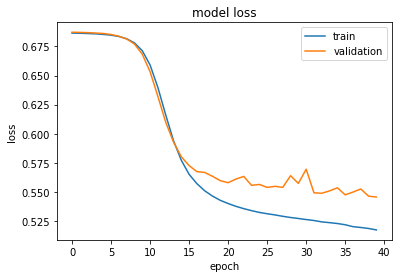

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')

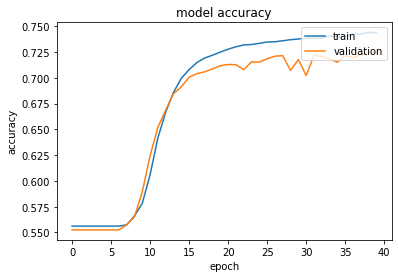

In [104]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train', 'validation'], loc= 'upper right')

In [114]:
model.fit([x_train_user_in, x_train_movie_in], y_ratings, verbose=1, epochs=40, batch_size=32, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5266 - mean_absolute_error: 0.3542 - acc: 0.7370 - val_loss: 0.5563 - val_mean_absolute_error: 0.3704 - val_acc: 0.7150
Epoch 2/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5247 - mean_absolute_error: 0.3538 - acc: 0.7374 - val_loss: 0.5510 - val_mean_absolute_error: 0.3625 - val_acc: 0.7205
Epoch 3/40
80000/80000 [==============================] - 5s 64us/step - loss: 0.5243 - mean_absolute_error: 0.3529 - acc: 0.7381 - val_loss: 0.5501 - val_mean_absolute_error: 0.3653 - val_acc: 0.7193
Epoch 4/40
80000/80000 [==============================] - 5s 63us/step - loss: 0.5232 - mean_absolute_error: 0.3517 - acc: 0.7378 - val_loss: 0.5577 - val_mean_absolute_error: 0.3699 - val_acc: 0.7153
Epoch 5/40
80000/80000 [==============================] - 5s 64us/step - loss: 0.5227 - mean_absolute_error: 0.3516 - acc: 0.7392 - val_loss: 0.54

* #### Therefore with 80k training datapoints & 20k validation datapoints:
    * MAE value with surprise SVD implementation: 0.3390
    * MAE value with surprise SVD++ implementation: 0.3563
    * MAE value after 40 epochs with matrix factorization with NN implementation: 0.3120 
    

